# Imports

In [1]:
import pandas as pd
import numpy as np
import utils.read_data as read
import utils.features as features
from utils.handlers.constants import UNK

from catboost import CatBoostRanker, Pool
from sklearn.model_selection import GroupKFold

from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

# Utils

In [2]:
SEED = 42

# Reading data

In [3]:
members = read.members("data/members.csv")

In [4]:
songs = read.songs("data/songs.csv")
song_extra_info = read.extra_info("data/song_extra_info.csv")

songs = songs.merge(song_extra_info, on="song_id", how="left")

In [5]:
train = read.train("data/train.csv")

# Generate features from data, e.g., raw age $\to$ somewhat of categorical desc. of user this is child, teenager etc.

In [ ]:
members = features.member(members)
songs = features.song(songs)

# Final data

In [6]:
data = train.merge(members, on="msno", how="left").merge(songs, on="song_id", how="left").astype({"msno": "category", "song_id": "category"})

data.source_screen_name = data.source_screen_name.cat.add_categories(UNK).fillna(UNK)
data.source_system_tab = data.source_system_tab.cat.add_categories(UNK).fillna(UNK)
data.source_type = data.source_type.cat.add_categories(UNK).fillna(UNK)

data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,composer,lyricist,language,name,artist_count,composer_count,lyricist_count,genre_count,isrc_year,isrc_country
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,<UNK>,<UNK>,7,...,Dan Smith| Mark Crew,<UNK>,52.0,Good Grief,1.0,2.0,0.0,1.0,16,GB
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,young,female,9,...,<UNK>,<UNK>,52.0,Lords of Cardboard,1.0,0.0,0.0,1.0,99,US
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,young,female,9,...,N. Jones、W. Adams、J. Lordan、D. Ingle,<UNK>,52.0,Hip Hop Is Dead(Album Version (Edited)),1.0,1.0,0.0,1.0,6,US
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,young,female,9,...,Kwadwo Donkoh,<UNK>,-1.0,Disco Africa,1.0,1.0,0.0,1.0,10,GB
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,<UNK>,<UNK>,7,...,Brett Young| Kelly Archer| Justin Ebach,<UNK>,52.0,Sleep Without You,1.0,3.0,0.0,1.0,16,QM


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 29 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   msno                     category
 1   song_id                  category
 2   source_system_tab        category
 3   source_screen_name       category
 4   source_type              category
 5   target                   int32   
 6   city                     category
 7   bd                       category
 8   gender                   category
 9   registered_via           category
 10  registration_init_year   category
 11  registration_init_month  category
 12  registration_init_day    category
 13  expiration_year          category
 14  expiration_month         category
 15  expiration_day           category
 16  song_length              float64 
 17  genre_ids                category
 18  artist_name              category
 19  composer                 category
 20  lyricist                

# Are there any NAN values left?

In [8]:
na_mask = data.isna().any(1)
print(na_mask.sum())

1607


not terrible, I guess, we will remove these as it is negligible in comparison with whole remaining data (~7 millions)

In [9]:
data = data[~na_mask]

here we have some problems: firstly, catboost on CPU kinda sucks. Secondly, on GPU it cannot handle more than 1024 items...

In [10]:
data = data.groupby("msno").head(1023).reset_index(drop=True)
data.target.value_counts()

1    3563752
0    3450391
Name: target, dtype: int64

In [11]:
categorical_features = data.select_dtypes(["category"]).columns.to_numpy()

data.sort_values("msno", kind="stable", inplace=True)

# Task 1. GBDT (via CatBoost cos we have lotta categorical features)

In [12]:
cfg = {
    "loss_function": "YetiRank", 
    "iterations": 150, 
    "custom_metric": ["NDCG", "QueryAUC:type=Ranking"], 
    "random_seed": SEED, 
    "metric_period": 10,
    "task_type": "GPU",
    "train_dir": "YetiRank/" 
}

In [13]:
X = data.drop("target", axis=1)
y = data.target.to_numpy()
q = data.msno.cat.codes.to_numpy()

In [14]:
scores = []
for train_idx, val_idx in GroupKFold(n_splits=5).split(X, y, q):
    X_train = X.iloc[train_idx]
    y_train = y[train_idx]
    
    X_val = X.iloc[val_idx]
    y_val = y[val_idx]
    
    q_train = q[train_idx]
    q_val = q[val_idx]
    
    pool_train = Pool(data=X_train, label=y_train, group_id=q_train, cat_features=categorical_features, has_header=True)
    pool_val = Pool(data=X_val, label=y_val, group_id=q_val, cat_features=categorical_features, has_header=True)
    
    model = CatBoostRanker(**cfg)
    model.fit(pool_train, eval_set=pool_val)
    
    scores.append(model.get_evals_result())

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6355956	best: 0.6355956 (0)	total: 639ms	remaining: 1m 35s
10:	test: 0.7845218	best: 0.7845218 (10)	total: 4.44s	remaining: 56.2s
20:	test: 0.7895664	best: 0.7895664 (20)	total: 8.27s	remaining: 50.8s
30:	test: 0.7906584	best: 0.7906584 (30)	total: 12.1s	remaining: 46.3s
40:	test: 0.7912163	best: 0.7912163 (40)	total: 15.9s	remaining: 42.3s
50:	test: 0.7914187	best: 0.7914187 (50)	total: 19.7s	remaining: 38.3s
60:	test: 0.7915700	best: 0.7915700 (60)	total: 23.6s	remaining: 34.4s
70:	test: 0.7920706	best: 0.7920706 (70)	total: 27.4s	remaining: 30.4s
80:	test: 0.7922996	best: 0.7922996 (80)	total: 31.2s	remaining: 26.6s
90:	test: 0.7917697	best: 0.7922996 (80)	total: 35s	remaining: 22.7s
100:	test: 0.7907831	best: 0.7922996 (80)	total: 38.8s	remaining: 18.8s
110:	test: 0.7912681	best: 0.7922996 (80)	total: 42.5s	remaining: 14.9s
120:	test: 0.7914118	best: 0.7922996 (80)	total: 46.3s	remaining: 11.1s
130:	test: 0.7912089	best: 0.7922996 (80)	total: 50.1s	remaining: 7.26s
140:	

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4732446	best: 0.4732446 (0)	total: 636ms	remaining: 1m 34s
10:	test: 0.7750853	best: 0.7750853 (10)	total: 4.45s	remaining: 56.2s
20:	test: 0.7815763	best: 0.7815763 (20)	total: 8.24s	remaining: 50.6s
30:	test: 0.7828368	best: 0.7828368 (30)	total: 12s	remaining: 46.2s
40:	test: 0.7833568	best: 0.7833568 (40)	total: 15.8s	remaining: 42.1s
50:	test: 0.7839526	best: 0.7839526 (50)	total: 19.6s	remaining: 38.1s
60:	test: 0.7846723	best: 0.7846723 (60)	total: 23.4s	remaining: 34.1s
70:	test: 0.7846941	best: 0.7846941 (70)	total: 27.2s	remaining: 30.3s
80:	test: 0.7851034	best: 0.7851034 (80)	total: 31s	remaining: 26.4s
90:	test: 0.7849656	best: 0.7851034 (80)	total: 34.8s	remaining: 22.6s
100:	test: 0.7847522	best: 0.7851034 (80)	total: 38.6s	remaining: 18.7s
110:	test: 0.7850714	best: 0.7851034 (80)	total: 42.5s	remaining: 14.9s
120:	test: 0.7855460	best: 0.7855460 (120)	total: 46.3s	remaining: 11.1s
130:	test: 0.7859758	best: 0.7859758 (130)	total: 50.1s	remaining: 7.27s
140:	

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5883166	best: 0.5883166 (0)	total: 601ms	remaining: 1m 29s
10:	test: 0.7747664	best: 0.7747664 (10)	total: 4.3s	remaining: 54.4s
20:	test: 0.7788893	best: 0.7788893 (20)	total: 8.02s	remaining: 49.2s
30:	test: 0.7806710	best: 0.7806710 (30)	total: 11.8s	remaining: 45.1s
40:	test: 0.7817497	best: 0.7817497 (40)	total: 15.5s	remaining: 41.3s
50:	test: 0.7821473	best: 0.7821473 (50)	total: 19.4s	remaining: 37.6s
60:	test: 0.7822032	best: 0.7822032 (60)	total: 23.1s	remaining: 33.8s
70:	test: 0.7823663	best: 0.7823663 (70)	total: 27s	remaining: 30s
80:	test: 0.7821895	best: 0.7823663 (70)	total: 30.8s	remaining: 26.2s
90:	test: 0.7821047	best: 0.7823663 (70)	total: 34.6s	remaining: 22.4s
100:	test: 0.7819301	best: 0.7823663 (70)	total: 38.5s	remaining: 18.7s
110:	test: 0.7815347	best: 0.7823663 (70)	total: 42.3s	remaining: 14.9s
120:	test: 0.7820988	best: 0.7823663 (70)	total: 46.2s	remaining: 11.1s
130:	test: 0.7820005	best: 0.7823663 (70)	total: 50s	remaining: 7.25s
140:	test:

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4731337	best: 0.4731337 (0)	total: 591ms	remaining: 1m 28s
10:	test: 0.7788003	best: 0.7788003 (10)	total: 3.7s	remaining: 46.8s
20:	test: 0.7826994	best: 0.7826994 (20)	total: 6.78s	remaining: 41.6s
30:	test: 0.7827484	best: 0.7827484 (30)	total: 9.86s	remaining: 37.9s
40:	test: 0.7835371	best: 0.7835371 (40)	total: 12.9s	remaining: 34.4s
50:	test: 0.7842377	best: 0.7842377 (50)	total: 16s	remaining: 31.1s
60:	test: 0.7847605	best: 0.7847605 (60)	total: 19.1s	remaining: 27.9s
70:	test: 0.7851932	best: 0.7851932 (70)	total: 22.3s	remaining: 24.8s
80:	test: 0.7849229	best: 0.7851932 (70)	total: 25.4s	remaining: 21.6s
90:	test: 0.7851312	best: 0.7851932 (70)	total: 28.5s	remaining: 18.5s
100:	test: 0.7849969	best: 0.7851932 (70)	total: 31.7s	remaining: 15.4s
110:	test: 0.7860453	best: 0.7860453 (110)	total: 34.8s	remaining: 12.2s
120:	test: 0.7861955	best: 0.7861955 (120)	total: 38s	remaining: 9.1s
130:	test: 0.7860236	best: 0.7861955 (120)	total: 41.1s	remaining: 5.96s
140:	t

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6863911	best: 0.6863911 (0)	total: 567ms	remaining: 1m 24s
10:	test: 0.7719551	best: 0.7719551 (10)	total: 3.68s	remaining: 46.5s
20:	test: 0.7796212	best: 0.7796212 (20)	total: 6.89s	remaining: 42.3s
30:	test: 0.7804516	best: 0.7804516 (30)	total: 10s	remaining: 38.5s
40:	test: 0.7806020	best: 0.7806020 (40)	total: 13.2s	remaining: 35s
50:	test: 0.7807303	best: 0.7807303 (50)	total: 16.3s	remaining: 31.6s
60:	test: 0.7805873	best: 0.7807303 (50)	total: 19.7s	remaining: 28.8s
70:	test: 0.7806880	best: 0.7807303 (50)	total: 23.1s	remaining: 25.7s
80:	test: 0.7806609	best: 0.7807303 (50)	total: 26.4s	remaining: 22.5s
90:	test: 0.7812658	best: 0.7812658 (90)	total: 29.6s	remaining: 19.2s
100:	test: 0.7813682	best: 0.7813682 (100)	total: 32.8s	remaining: 15.9s
110:	test: 0.7811025	best: 0.7813682 (100)	total: 35.9s	remaining: 12.6s
120:	test: 0.7812785	best: 0.7813682 (100)	total: 39.2s	remaining: 9.38s
130:	test: 0.7815042	best: 0.7815042 (130)	total: 42.5s	remaining: 6.16s
140

/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Iteration')

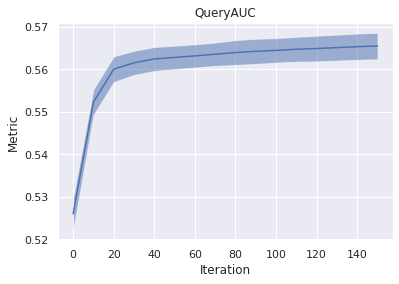

In [15]:
quac = np.vstack([x["validation"]["QueryAUC:type=Ranking"] for x in scores])

mean = quac.mean(0)
std = quac.std(0)

x = np.arange(cfg["iterations"] // cfg["metric_period"] + 1) * cfg["metric_period"]

ax = sns.lineplot(x, mean)
ax.fill_between(x, mean - std, mean + std, alpha = 0.5)

ax.set_title("QueryAUC")
ax.set_ylabel("Metric")
ax.set_xlabel("Iteration")

/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Iteration')

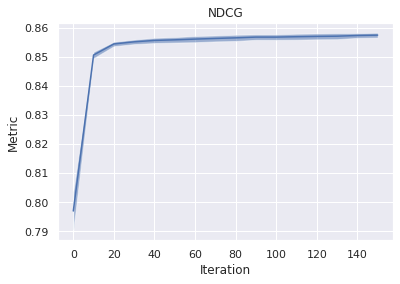

In [16]:
ndcg = np.vstack([x["validation"]["NDCG:type=Base"] for x in scores])

mean = ndcg.mean(0)
std = ndcg.std(0)

x = np.arange(cfg["iterations"] // cfg["metric_period"] + 1) * cfg["metric_period"]

ax = sns.lineplot(x, mean)
ax.fill_between(x, mean - std, mean + std, alpha = 0.5)

ax.set_title("NDCG")
ax.set_ylabel("Metric")
ax.set_xlabel("Iteration")